In [5]:
!mkdir -p bank_churn && cd bank_churn && kaggle competitions download -c playground-series-s4e1 && unzip playground-series-s4e1.zip

... resuming from 0 bytes (7141098 bytes left) ...
 73%|███████████████████████████▉          | 5.00M/6.81M [00:00<00:00, 28.2MB/s]
100%|██████████████████████████████████████| 6.81M/6.81M [00:00<00:00, 31.9MB/s]
Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [21]:
train_df = pd.read_csv("bank_churn/train.csv")
test_df = pd.read_csv("bank_churn/test.csv")

len(train_df), len(test_df)

(165034, 110023)

In [23]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


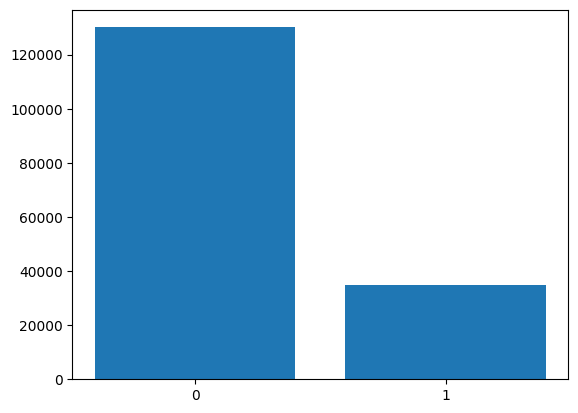

In [19]:
x = train_df.groupby('Exited').size()
plt.bar([0, 1], x)
plt.xticks([0, 1])
plt.show()

In [160]:
features = [
    "NumOfProducts",
    "CreditScore",
    "Geography",
    "Gender",
    "Age",
    "Tenure",
    "Balance",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary"
]


In [144]:
train_df['Geography'] = train_df['Geography'].astype('category')
train_df['Gender'] = train_df['Gender'].astype('category')

test_df = test_df.astype(dtype={
    "Geography": train_df.dtypes['Geography'],
    "Gender": train_df.dtypes['Gender'],
})

original_train_df = train_df

In [145]:
train_df, val_df = train_test_split(original_train_df, random_state=42, test_size=0.15)

In [206]:
len(train_df[train_df.Exited == 0]) / len(train_df)

0.7879499480022812

In [199]:


params = {  
  'objective'             : 'binary:logistic',
  'eval_metric'           : "auc",
  'max_depth': 8,
  'min_child_weight': 9, 
  'learning_rate': 0.015784217705381666,
  'n_estimators': 928, 
  'subsample': 0.8311128887439883,
  'colsample_bytree': 0.3454344427319984,
}

# n_estimators=50,
# max_depth=4,

import xgboost
clf = xgboost.XGBClassifier(
    random_state=42,
    # scale_pos_weight=len(train_df[train_df.Exited == 0]) / len(train_df[train_df.Exited == 1]),
    enable_categorical=True,
    # **params,
)
clf.fit(train_df[features], train_df['Exited'])

score = clf.predict(val_df[features])
print(accuracy_score(score, val_df['Exited']))
print(classification_report(
    score,
    val_df['Exited'],
))


0.8658872730729018
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     17701
           1       0.56      0.74      0.64      3341

    accuracy                           0.87     21042
   macro avg       0.75      0.81      0.78     21042
weighted avg       0.89      0.87      0.87     21042



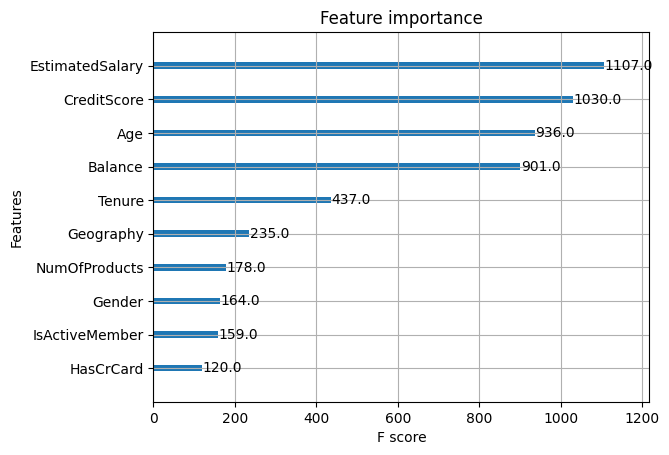

In [201]:
from xgboost import plot_importance

plot_importance(clf)
plt.show()

In [195]:
ids = test_df['id']
exit_prop = clf.predict_proba(test_df[features])[:, 1]
pd.DataFrame({"id": ids, "Exited": exit_prop}).to_csv("bank_churn/submission.csv", index=False)